In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import keras 
from tensorflow.keras.applications import ResNet50
%matplotlib inline
import matplotlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
from tensorflow.keras.models import load_model
import pickle
from tensorflow.keras import regularizers


In [3]:
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("Matplotlib version:", matplotlib.__version__)

TensorFlow version: 2.16.1
Keras version: 3.3.3
Matplotlib version: 3.9.0


In [4]:
# mostrar a quantidade de imagens e classes de treinamento 
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    
    "C:/Users/brena/OneDrive/Documentos/bootcamp/projeto-final/Fruits/train",
    
    image_size=(180, 180),  # Definir o tamanho das imagens
    
    batch_size=32 # quantidade de imagens por lote 

)

Found 9636 files belonging to 6 classes.


In [5]:
# mostrar o nome das classes
nomes_classes = dataset.class_names
nomes_classes

['Apple', 'Banana', 'Grape', 'Mango', 'Orange', 'Strawberry']

In [6]:
# Contar a quantidade de imagens por classe
class_counts = {class_name: 0 for class_name in dataset.class_names}

for images, labels in dataset:
    for label in labels:
        class_name = dataset.class_names[label]
        class_counts[class_name] += 1

# Exibir a quantidade de imagens por classe
for class_name, count in class_counts.items():
    print(f'A classe {class_name} tem {count} imagens')

# Exibir a quantidade total de classes
num_classes = len(dataset.class_names)
print(f'Total de classes: {num_classes}')

# Exibir a quantidade total de imagens
total_images = sum(class_counts.values())
print(f'Total de imagens: {total_images}')

# Exibir a porcentagem de imagens por classe
for class_name, count in class_counts.items():
    percentage = (count / total_images) * 100
    print(f'A classe {class_name} tem {percentage:.2f}% das imagens')

A classe Apple tem 1940 imagens
A classe Banana tem 1863 imagens
A classe Grape tem 1940 imagens
A classe Mango tem 1921 imagens
A classe Orange tem 32 imagens
A classe Strawberry tem 1940 imagens
Total de classes: 6
Total de imagens: 9636
A classe Apple tem 20.13% das imagens
A classe Banana tem 19.33% das imagens
A classe Grape tem 20.13% das imagens
A classe Mango tem 19.94% das imagens
A classe Orange tem 0.33% das imagens
A classe Strawberry tem 20.13% das imagens


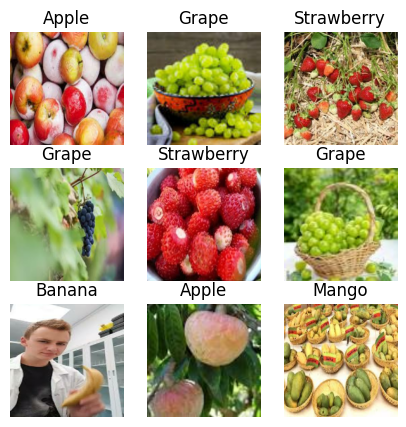

In [7]:
plt.figure(figsize=(5, 5))

for images, labels in dataset.take(1):  # Pegar um lote de imagens
    
    for i in range(9):  # Mostrar as primeiras 9 imagens
        
        ax = plt.subplot(3, 3, i + 1) # exibição das imagens 3X3
        
        plt.imshow(images[i].numpy().astype("uint8"))
        
        plt.title(nomes_classes[labels[i]]) # para mostrar o nome da classe
        
        plt.axis("off")
        
plt.show()

In [8]:
# Definindo image_size e batch_size
image_size = (180, 180)
batch_size = 32

# Caminhos para os dados de treinamento e validação
treinamento_data = "C:/Users/brena/OneDrive/Documentos/bootcamp/projeto-final/Fruits/train"
validaca_data = "C:/Users/brena/OneDrive/Documentos/bootcamp/projeto-final/Fruits/valid"
teste_data ='C:/Users/brena/OneDrive/Documentos/bootcamp/projeto-final/Fruits/test'

X_test = validaca_data
X_train = treinamento_data

# Carregando os datasets
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    treinamento_data,
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    validaca_data,
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    teste_data,
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)


test_generator = test_datagen.flow_from_directory(
    'C:/Users/brena/OneDrive/Documentos/bootcamp/projeto-final/Fruits/test',
    target_size=(180, 180),
    batch_size=32,
    class_mode='sparse',
    shuffle=False  # Mantenha a ordem para que as previsões correspondam aos rótulos
)


Found 9636 files belonging to 6 classes.
Found 226 files belonging to 6 classes.
Found 155 files belonging to 6 classes.
Found 155 images belonging to 6 classes.


In [9]:

import tensorflow as tf

# Normalização dos dados usando TensorFlow
train_data = train_data.map(lambda x, y: (tf.image.per_image_standardization(x), y))
val_data = val_data.map(lambda x, y: (tf.image.per_image_standardization(x), y))
test_data = test_data.map(lambda x, y: (tf.image.per_image_standardization(x), y))

# Continuar com a definição e treinamento do modelo...


## aplicando modelo de rede neural

In [10]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.regularizers import l2

# Definindo o modelo
modelo2 = models.Sequential()

# Adicionando camadas com regularização L2
modelo2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3), kernel_regularizer=regularizers.l2(0.01)))
modelo2.add(layers.MaxPooling2D((2, 2)))

modelo2.add(layers.Conv2D(64,(3,3), activation='relu', kernel_regularizer=l2(0.01)))
modelo2.add(layers.MaxPooling2D((2, 2)))


# Flatten antes da camada densa
modelo2.add(layers.Flatten())
modelo2.add(layers.Dropout(0.5))

# Camada densa com regularização L2
modelo2.add(layers.Dense(16, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

# Compilando o modelo
modelo2.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])


c:\Users\brena\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# data augmentation - usada para diminuir o overfitting
data_augmentation = tf;keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

In [11]:
history = modelo2.fit(
    train_data,
    epochs=20,
    validation_data = val_data,
)

Epoch 1/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 111s 359ms/step - accuracy: 0.4491 - loss: 2.2315 - val_accuracy: 0.5000 - val_loss: 1.5628
Epoch 2/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 106s 349ms/step - accuracy: 0.5776 - loss: 1.4303 - val_accuracy: 0.5354 - val_loss: 1.4747
Epoch 3/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 112s 371ms/step - accuracy: 0.6229 - loss: 1.3094 - val_accuracy: 0.5619 - val_loss: 1.4006
Epoch 4/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 139s 361ms/step - accuracy: 0.6411 - loss: 1.2861 - val_accuracy: 0.5133 - val_loss: 1.5546
Epoch 5/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 110s 365ms/step - accuracy: 0.6442 - loss: 1.2790 - val_accuracy: 0.5885 - val_loss: 1.3887
Epoch 6/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 89s 293ms/step - accuracy: 0.6549 - loss: 1.2463 - val_accuracy: 0.5929 - val_loss: 1.3839
Epoch 7/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 82s 270ms/step - accuracy: 0.6711 - loss: 1.2418 - val_accuracy: 0.5708 - val_loss: 1.4536
Epoch 8/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 81s 267ms/step - accuracy: 0.6861 - lo

In [1]:
with open('C:/Users/brena/OneDrive/Documentos/github/Frutas-ML/history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

NameError: name 'pickle' is not defined

In [32]:

modelo2.save('C:/Users/brena/OneDrive/Documentos/github/Frutas-ML/models/modelo2.h5')

In [33]:
modelo2 = load_model('C:/Users/brena/OneDrive/Documentos/github/Frutas-ML/models/modelo2.h5')

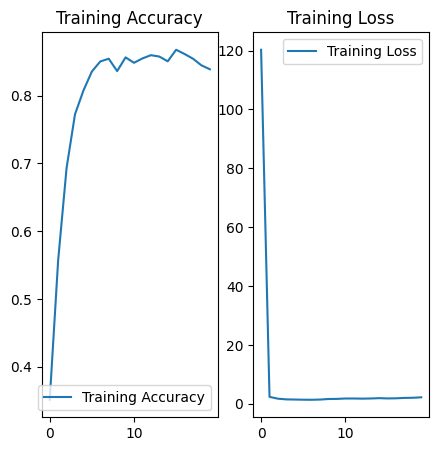

In [35]:
# mostrar o historico de treinamento

acc = history.history['accuracy']

loss = history.history['loss']

epochs_range = range(20)

plt.figure(figsize=(5, 5))

plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label='Training Accuracy')

plt.legend(loc='lower right')

plt.title('Training Accuracy')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, loss, label='Training Loss')

plt.legend(loc='upper right')

plt.title('Training Loss')

plt.show()

In [36]:
# avaliar o modelo

train_loss, train_acc = modelo2.evaluate(train_data, verbose=2)

print('\nTraining accuracy:', train_acc)

print('\nTraining loss:', train_loss)

302/302 - 18s - 59ms/step - accuracy: 0.9378 - loss: 1.9359

Training accuracy: 0.9378373026847839

Training loss: 1.935854196548462


In [38]:
# Avaliando o modelo no conjunto de validação
val_loss, val_accuracy = modelo2.evaluate(val_data)
print(f'Validação - Perda: {val_loss}, Acurácia: {val_accuracy}')


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4568 - loss: 5.0008
Validação - Perda: 5.41481351852417, Acurácia: 0.44690266251564026


In [39]:
# Avaliando o modelo no conjunto de teste
test_loss, test_acc = modelo2.evaluate(test_data, verbose=2)

print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)


5/5 - 0s - 83ms/step - accuracy: 0.3484 - loss: 8.9194

Test accuracy: 0.34838709235191345

Test loss: 8.919395446777344


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


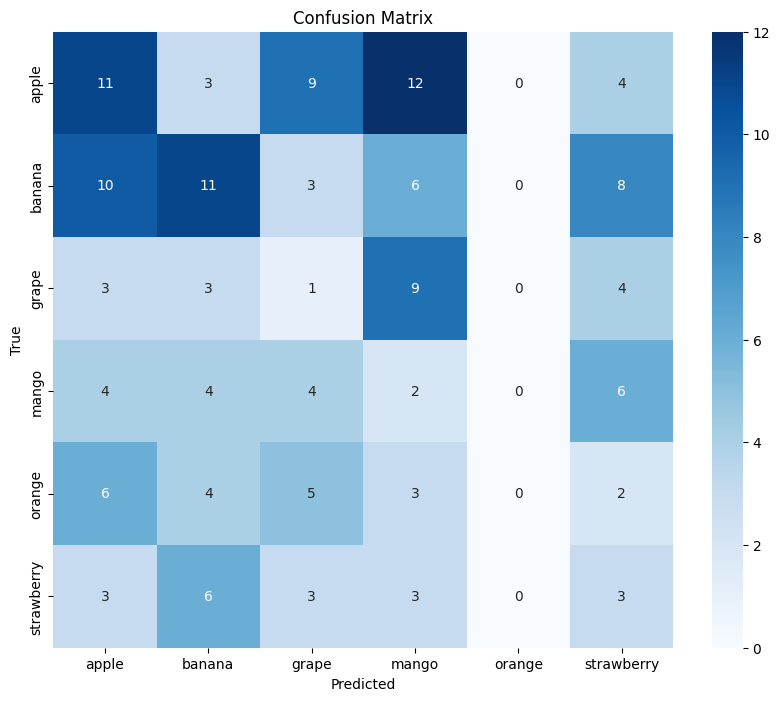

Classification Report:
              precision    recall  f1-score   support

       apple       0.30      0.28      0.29        39
      banana       0.35      0.29      0.32        38
       grape       0.04      0.05      0.04        20
       mango       0.06      0.10      0.07        20
      orange       0.00      0.00      0.00        20
  strawberry       0.11      0.17      0.13        18

    accuracy                           0.18       155
   macro avg       0.14      0.15      0.14       155
weighted avg       0.19      0.18      0.18       155



c:\Users\brena\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\brena\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\brena\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Definindo manualmente os nomes das classes (substitua com suas classes reais)
class_names = ['apple', 'banana', 'grape', 'mango', 'orange', 'strawberry']

# Fazendo previsões no conjunto de teste
y_pred = modelo2.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# Obtendo os rótulos reais do conjunto de teste
y_true = np.concatenate([y for _, y in test_data], axis=0)

# Calculando a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plotando a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Relatório de classificação
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(report)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


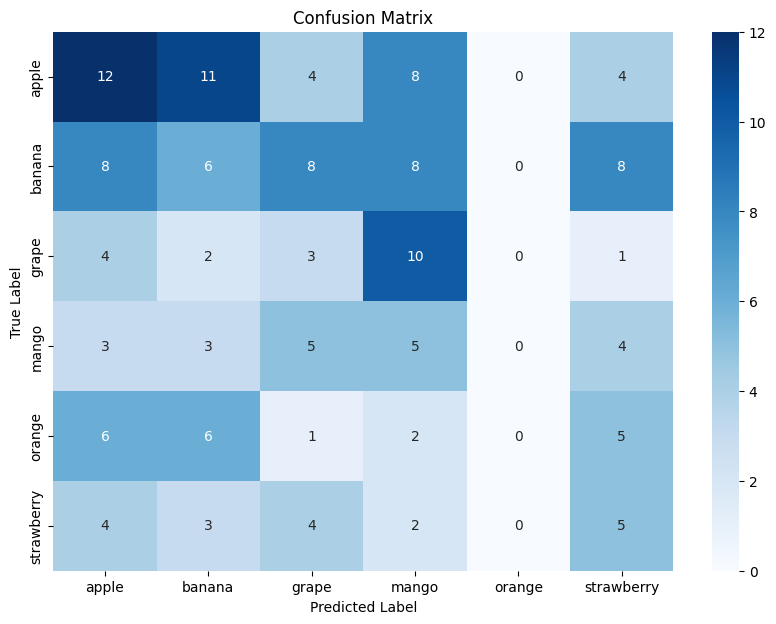

Classification Report:
              precision    recall  f1-score   support

       apple       0.32      0.31      0.32        39
      banana       0.19      0.16      0.17        38
       grape       0.12      0.15      0.13        20
       mango       0.14      0.25      0.18        20
      orange       0.00      0.00      0.00        20
  strawberry       0.19      0.28      0.22        18

    accuracy                           0.20       155
   macro avg       0.16      0.19      0.17       155
weighted avg       0.18      0.20      0.19       155



c:\Users\brena\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\brena\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\brena\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [42]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Definindo manualmente os nomes das classes
class_names = ['apple', 'banana', 'grape', 'mango', 'orange', 'strawberry']

# Fazendo previsões no conjunto de teste
y_pred = modelo2.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)


# Calculando a matriz de confusão
cm = confusion_matrix(y_true, y_pred_classes)

# Visualizando a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Relatório de classificação
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(report)
